# 📊 Day 3.1 - Patient-Wise Data Splitting

## 🎯 Learning Objectives

In this notebook, you'll learn:
1. **Why patient-wise splitting matters** - prevents data leakage
2. **Stratified splits** - maintains class distribution across train/val/test
3. **GroupKFold** - ensures no patient appears in multiple splits

## 🧠 Theory: Why Patient-Wise Split?

### ❌ **Problem with Random Splitting:**
If we randomly split images, multiple slices from the **same patient** could end up in both training and test sets.

**Result:** Model memorizes patient-specific patterns instead of learning generalizable tumor features → inflated test accuracy!

### ✅ **Solution: Group by Patient ID**
- All slices from one patient go into **only ONE** split (train, val, OR test)
- Forces the model to generalize to **unseen patients**
- More realistic evaluation of clinical deployment

---

## 📐 Split Strategy

- **Training:** 70% of patients (for learning)
- **Validation:** 15% of patients (for hyperparameter tuning)
- **Test:** 15% of patients (final evaluation, never touched during training)

We'll use `StratifiedGroupKFold` to maintain class balance while grouping by patient.

## 🔧 Setup

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 📂 Load Metadata

In [8]:
# Load metadata
meta = pd.read_csv("../../outputs/data_splits/metadata.csv")

print(f"Total images: {len(meta)}")
print(f"\nFirst few rows:")
meta.head()

Total images: 3064

First few rows:


filename  label patient_id  original_mat_name
0  pid101029_1465.png      3     101029               1465
1  pid105187_1561.png      3     105187               1561
2  pid101017_1643.png      3     101017               1643
3  pid101145_1652.png      3     101145               1652
4  pid111075_1233.png      3     111075               1233

In [9]:
# Add filepath for enhanced images
meta['filepath'] = meta.apply(
    lambda x: f"../../outputs/ce_mri_enhanced/{x.label}/{x.filename}", 
    axis=1
)

# Verify files exist (sample check)
sample_exists = os.path.exists(meta['filepath'].iloc[0])
print(f"Sample file exists: {sample_exists}")
print(f"\nSample path: {meta['filepath'].iloc[0]}")

Sample file exists: True

Sample path: ../../outputs/ce_mri_enhanced/3/pid101029_1465.png


## 🔍 Exploratory Analysis

In [10]:
# Class distribution
print("📊 Class Distribution:")
class_counts = meta['label'].value_counts().sort_index()
print(class_counts)
print(f"\nPercentages:")
print(class_counts / len(meta) * 100)

📊 Class Distribution:
label
1     708
2    1426
3     930
Name: count, dtype: int64

Percentages:
label
1    23.10705
2    46.54047
3    30.35248
Name: count, dtype: float64


In [5]:
# Patient distribution
print(f"👥 Total unique patients: {meta['patient_id'].nunique()}")
print(f"\n📈 Slices per patient statistics:")
slices_per_patient = meta.groupby('patient_id').size()
print(slices_per_patient.describe())

👥 Total unique patients: 233

📈 Slices per patient statistics:
count    233.000000
mean      13.150215
std        7.655779
min        1.000000
25%        7.000000
50%       13.000000
75%       18.000000
max       38.000000
dtype: float64


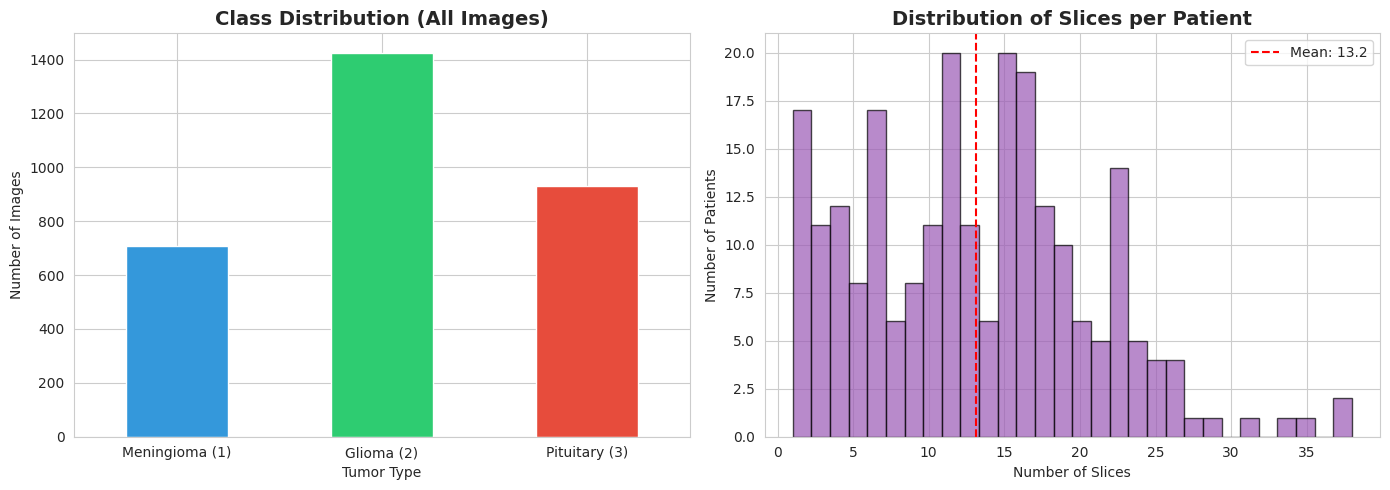

✅ Visualization saved


In [12]:
# Create visualizations directory if it doesn't exist
os.makedirs('../../outputs/visualizations', exist_ok=True)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (All Images)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tumor Type')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(['Meningioma (1)', 'Glioma (2)', 'Pituitary (3)'], rotation=0)

# Slices per patient
axes[1].hist(slices_per_patient, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Slices per Patient', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Slices')
axes[1].set_ylabel('Number of Patients')
axes[1].axvline(slices_per_patient.mean(), color='red', linestyle='--', 
                label=f'Mean: {slices_per_patient.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_01_data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")

## 🔀 Create Stratified Patient-Wise Splits

### Strategy:
1. Use `StratifiedGroupKFold` with 5 folds → gives us 80/20 split
2. Take first fold as test set (20% of patients)
3. From remaining 80%, take 15% as validation (12% of total)
4. Final split: **68% train, 12% val, 20% test**

In [13]:
# We need to aggregate by patient first to ensure stratification works on patient level
# Get one row per patient with their dominant class
patient_labels = meta.groupby('patient_id')['label'].agg(lambda x: x.mode()[0]).reset_index()
print(f"Unique patients: {len(patient_labels)}")
print(f"\nPatient-level class distribution:")
print(patient_labels['label'].value_counts().sort_index())

Unique patients: 233

Patient-level class distribution:
label
1    82
2    89
3    62
Name: count, dtype: int64


In [14]:
# Initialize StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Get first split (80% train+val, 20% test at patient level)
train_val_patients, test_patients = next(
    sgkf.split(
        patient_labels, 
        patient_labels['label'], 
        groups=patient_labels['patient_id']
    )
)

# Get patient IDs
test_patient_ids = patient_labels.iloc[test_patients]['patient_id'].values
train_val_patient_ids = patient_labels.iloc[train_val_patients]['patient_id'].values

print(f"Test patients: {len(test_patient_ids)}")
print(f"Train+Val patients: {len(train_val_patient_ids)}")

Test patients: 47
Train+Val patients: 186


In [15]:
# Split images based on patient IDs
test_meta = meta[meta['patient_id'].isin(test_patient_ids)].copy()
train_val_meta = meta[meta['patient_id'].isin(train_val_patient_ids)].copy()

print(f"Test images: {len(test_meta)}")
print(f"Train+Val images: {len(train_val_meta)}")

Test images: 680
Train+Val images: 2384


In [16]:
# Now split train_val into train and validation (85/15 split)
# Use stratified sampling to maintain class balance
from sklearn.model_selection import train_test_split

# Get patient IDs from train_val
train_val_patient_labels = patient_labels[patient_labels['patient_id'].isin(train_val_patient_ids)]

# Split patients (not images) into train and val
train_patients, val_patients = train_test_split(
    train_val_patient_labels['patient_id'],
    test_size=0.15,
    stratify=train_val_patient_labels['label'],
    random_state=42
)

# Split images based on patient assignment
train_meta = train_val_meta[train_val_meta['patient_id'].isin(train_patients)].copy()
val_meta = train_val_meta[train_val_meta['patient_id'].isin(val_patients)].copy()

print(f"✅ Final Split:")
print(f"  Train: {len(train_meta)} images from {len(train_patients)} patients")
print(f"  Val:   {len(val_meta)} images from {len(val_patients)} patients")
print(f"  Test:  {len(test_meta)} images from {len(test_patient_ids)} patients")
print(f"\nTotal: {len(train_meta) + len(val_meta) + len(test_meta)} images")

✅ Final Split:
  Train: 2059 images from 158 patients
  Val:   325 images from 28 patients
  Test:  680 images from 47 patients

Total: 3064 images


## ✅ Verify Split Quality

In [17]:
# Check for patient leakage
train_patients_set = set(train_meta['patient_id'])
val_patients_set = set(val_meta['patient_id'])
test_patients_set = set(test_meta['patient_id'])

train_val_overlap = train_patients_set & val_patients_set
train_test_overlap = train_patients_set & test_patients_set
val_test_overlap = val_patients_set & test_patients_set

print("🔍 Patient Leakage Check:")
print(f"  Train-Val overlap: {len(train_val_overlap)} patients ✅" if len(train_val_overlap) == 0 else f"  ❌ WARNING: {len(train_val_overlap)} patients overlap!")
print(f"  Train-Test overlap: {len(train_test_overlap)} patients ✅" if len(train_test_overlap) == 0 else f"  ❌ WARNING: {len(train_test_overlap)} patients overlap!")
print(f"  Val-Test overlap: {len(val_test_overlap)} patients ✅" if len(val_test_overlap) == 0 else f"  ❌ WARNING: {len(val_test_overlap)} patients overlap!")

🔍 Patient Leakage Check:
  Train-Val overlap: 0 patients ✅
  Train-Test overlap: 0 patients ✅
  Val-Test overlap: 0 patients ✅


In [18]:
# Check class distribution across splits
print("\n📊 Class Distribution Across Splits:\n")

splits_summary = pd.DataFrame({
    'Train': train_meta['label'].value_counts().sort_index(),
    'Val': val_meta['label'].value_counts().sort_index(),
    'Test': test_meta['label'].value_counts().sort_index()
})

print("Counts:")
print(splits_summary)
print("\nPercentages:")
print(splits_summary.div(splits_summary.sum()) * 100)


📊 Class Distribution Across Splits:

Counts:
       Train  Val  Test
label                  
1        446   50   212
2        966  163   297
3        647  112   171

Percentages:
           Train        Val       Test
label                                 
1      21.661000  15.384615  31.176471
2      46.915979  50.153846  43.676471
3      31.423021  34.461538  25.147059


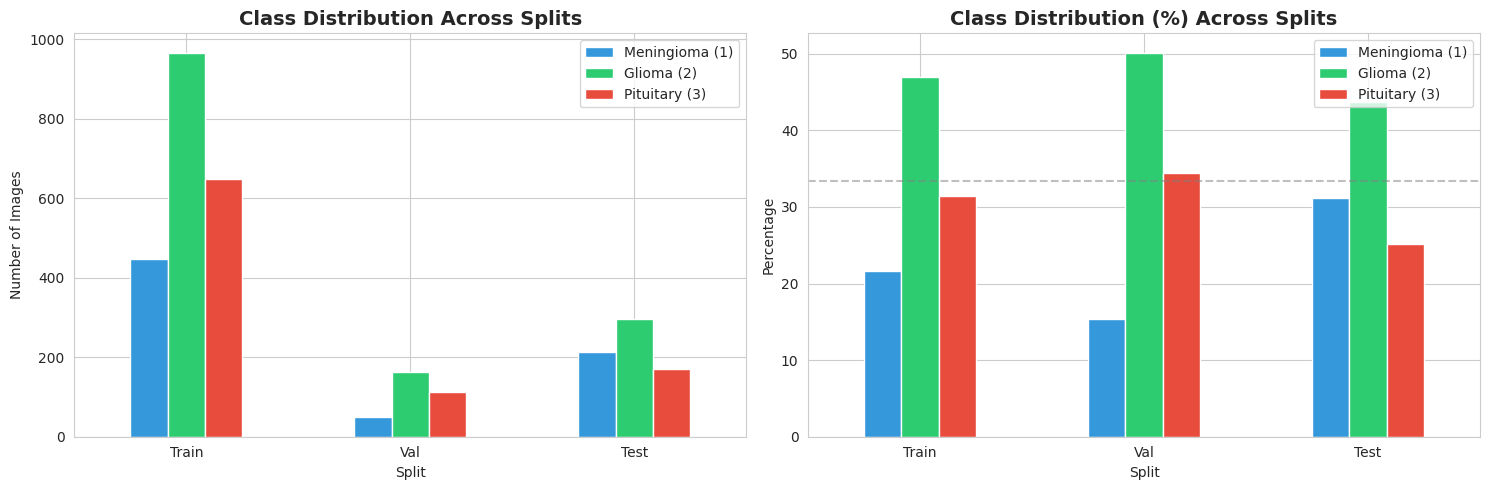

✅ Visualization saved


In [19]:
# Visualize split distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked bar chart - absolute counts
splits_summary.T.plot(kind='bar', stacked=False, ax=axes[0], 
                       color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split')
axes[0].set_ylabel('Number of Images')
axes[0].legend(['Meningioma (1)', 'Glioma (2)', 'Pituitary (3)'], loc='upper right')
axes[0].set_xticklabels(['Train', 'Val', 'Test'], rotation=0)

# Percentage comparison
percentages = splits_summary.div(splits_summary.sum()) * 100
percentages.T.plot(kind='bar', ax=axes[1], 
                    color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_title('Class Distribution (%) Across Splits', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split')
axes[1].set_ylabel('Percentage')
axes[1].legend(['Meningioma (1)', 'Glioma (2)', 'Pituitary (3)'], loc='upper right')
axes[1].set_xticklabels(['Train', 'Val', 'Test'], rotation=0)
axes[1].axhline(33.33, color='gray', linestyle='--', alpha=0.5, label='33.33% (perfect balance)')

plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_01_split_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved")

## 💾 Save Splits

In [20]:
# Create data_splits directory if it doesn't exist
os.makedirs('../../outputs/data_splits', exist_ok=True)

# Convert label to string for compatibility with ImageDataGenerator
train_meta['label'] = train_meta['label'].astype(str)
val_meta['label'] = val_meta['label'].astype(str)
test_meta['label'] = test_meta['label'].astype(str)

# Save splits
train_meta.to_csv('../../outputs/data_splits/train_split.csv', index=False)
val_meta.to_csv('../../outputs/data_splits/val_split.csv', index=False)
test_meta.to_csv('../../outputs/data_splits/test_split.csv', index=False)

print("✅ Split CSVs saved:")
print(f"  - train_split.csv ({len(train_meta)} images)")
print(f"  - val_split.csv ({len(val_meta)} images)")
print(f"  - test_split.csv ({len(test_meta)} images)")

✅ Split CSVs saved:
  - train_split.csv (2059 images)
  - val_split.csv (325 images)
  - test_split.csv (680 images)


## 📝 Summary Statistics

In [21]:
summary = {
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Patients': [len(train_patients), len(val_patients), len(test_patient_ids), 
                 len(train_patients) + len(val_patients) + len(test_patient_ids)],
    'Images': [len(train_meta), len(val_meta), len(test_meta), 
               len(train_meta) + len(val_meta) + len(test_meta)],
    'Percentage': [
        f"{len(train_meta)/len(meta)*100:.1f}%",
        f"{len(val_meta)/len(meta)*100:.1f}%",
        f"{len(test_meta)/len(meta)*100:.1f}%",
        "100.0%"
    ]
}

summary_df = pd.DataFrame(summary)
print("\n📊 Final Split Summary:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../../outputs/data_splits/split_summary.csv', index=False)
print("\n✅ Summary saved to split_summary.csv")


📊 Final Split Summary:
     Split  Patients  Images Percentage
     Train       158    2059      67.2%
Validation        28     325      10.6%
      Test        47     680      22.2%
     Total       233    3064     100.0%

✅ Summary saved to split_summary.csv


## 🎓 Key Takeaways

✅ **No Patient Leakage**: Every patient appears in only ONE split

✅ **Stratified**: Class distribution is similar across all splits

✅ **Reproducible**: Random seed (42) ensures same splits every time

✅ **Ready for Training**: CSVs contain filepaths for direct use with data generators

---

### 🚀 Next Steps:
Move to **day3_02_data_augmentation.ipynb** to build the augmentation pipeline!